In [ ]:
!cd simglucose

/bin/bash: line 0: cd: simglucose: No such file or directory


In [ ]:
!cd /content/PINN-CGM-1/simglucose

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime


# convert datetime string to integer (seconds since unix epoch)
def dt2int(dtstr, fmt="%Y-%m-%d %H:%M:%S"):
    return int(datetime.strptime(dtstr, fmt).strftime("%s"))


def visualize_meal(meal_time, meal_data, dt_min=None, dt_max=None, fmt="-"):
    plt.plot(meal_time, meal_data, fmt, color="orange")
    plt.xlabel("Epoch Time")
    plt.ylabel("Meal Size (g)")
    # plt.xlim(dt_min, dt_max)
    # plt.xticks(np.arange(dt_min, dt_max, 10000), rotation=90)


# visualize insulin data
def visualize_insulin(insulin_time, insulin_data, dt_min=None, dt_max=None, fmt="-"):
    plt.plot(insulin_time, insulin_data, fmt, color="green")
    plt.xlabel("Epoch Time")
    plt.ylabel("Insulin Delivered (mU)")
    # plt.xlim(dt_min, dt_max)
    # plt.xticks(np.arange(dt_min, dt_max, 10000), rotation=90)


# visualize cgm data
def visualize_cgm(cgm_time, cgm_data, dt_min=None, dt_max=None, fmt="-"):
    plt.plot(cgm_time, cgm_data, fmt, color="red")
    plt.xlabel("Epoch Time")
    plt.ylabel("BGL (mg/dL)")
    # plt.xlim(dt_min, dt_max)
    # plt.xticks(np.arange(dt_min, dt_max, 10000), rotation=90)


# visualize all data
def visualize(cgm_data, meal_data, insulin_data, dt_min=None, dt_max=None, fmt="-"):
    plt.figure(figsize=(8, 10))

    plt.subplot(311)
    visualize_meal(*meal_data, dt_min, dt_max, fmt)

    plt.subplot(312)
    visualize_insulin(*insulin_data, dt_min, dt_max, fmt)

    plt.subplot(313)
    visualize_cgm(*cgm_data, dt_min, dt_max, fmt)

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import pandas as pd


# utility function to interpolate data
def interpolate(cgm_data, meal_data, insulin_data, resolution=1 * 60):
    # interpolate data for fitting
    t_min = min(
        (
            meal_data.LocalDtTm.min(),
            insulin_data.LocalDeliveredDtTm.min(),
            cgm_data.LocalDtTm.min(),
        )
    )
    t_max = max(
        (
            meal_data.LocalDtTm.max(),
            insulin_data.LocalDeliveredDtTm.max(),
            cgm_data.LocalDtTm.max(),
        )
    )
    # resolution = 1 * 60   # 1 min

    t_interp = np.arange(t_min, t_max, resolution)

    meal_interp = np.zeros_like(t_interp)
    for _, row in meal_data.iterrows():
        meal_interp[int((row.LocalDtTm - t_interp[0]) // 60)] = row.MealSize

    insulin_interp = np.zeros_like(t_interp)
    for _, row in insulin_data.iterrows():
        insulin_interp[
            int((row.LocalDeliveredDtTm - t_interp[0]) // 60)
        ] = row.DeliveredValue

    cgm_interp = np.interp(t_interp, cgm_data["LocalDtTm"], cgm_data["CGM"])

    return t_interp, cgm_interp, meal_interp, insulin_interp


# C3R data class
class C3RData:
    def __init__(
        self,
        data_dir,
        cgm_data="MonitorCGM.txt",
        meal_data="MonitorMeal.txt",
        insulin_data="MonitorTotalBolus.txt",
    ):
        self.data_dir = data_dir
        self.cgm_data = pd.read_csv(f"{data_dir}/{cgm_data}", sep="|")
        self.meal_data = pd.read_csv(f"{data_dir}/{meal_data}", sep="|")
        self.insulin_data = pd.read_csv(f"{data_dir}/{insulin_data}", sep="|")

    def get_case_df(self, df, deident_id, from_dt, to_dt, dtcol="LocalDtTm"):
        df_case = df.copy()
        df_case = df_case.loc[df_case.DeidentID == deident_id]
        df_case[dtcol] = df_case[dtcol].map(dt2int)
        df_case = df_case.sort_values(by=[dtcol]).reset_index()
        df_case = df_case.loc[(df_case[dtcol] >= from_dt) & (df_case[dtcol] < to_dt)]

        return df_case

    def get_dates(self, deident_id):
        cgm_df = self.cgm_data
        cgm_dates = (
            cgm_df["LocalDtTm"]
            .map(lambda dt: dt[:10])
            .loc[cgm_df["DeidentID"] == deident_id]
            .sort_values()
            .unique()
        )

        return cgm_dates

    # get data of a given case
    def get_case(self, deident_id, from_dt, to_dt):
        from_dt = dt2int(from_dt)
        to_dt = dt2int(to_dt)

        cgm = self.get_case_df(self.cgm_data, deident_id, from_dt, to_dt)
        meal = self.get_case_df(self.meal_data, deident_id, from_dt, to_dt)
        insulin = self.get_case_df(
            self.insulin_data,
            deident_id,
            from_dt,
            to_dt,
            "LocalDeliveredDtTm",
        )

        return cgm, meal, insulin


In [ ]:
!pip install deap

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

import sys
sys.path.append('/content/PINN-CGM-1/simglucose')

from collections import namedtuple
from simglucose.patient.t1dpatient import T1DPatient

from simglucose.sensor.cgm import CGMSensor
from simglucose.simulation.env import T1DSimEnv
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.sim_engine import SimObj, sim
from simglucose.simulation.scenario import CustomScenario
from simglucose.controller.basal_bolus_ctrller import BBController

from tqdm.notebook import tqdm, trange
from deap import base, creator, tools, cma

In [ ]:
# config
GLOBAL_SEED = 0
RESULTS_PATH = "results/"

# better plots
sns.set()

# tqdm
tqdm.pandas()

In [ ]:
# load dataset
c3r = C3RData(data_dir="/content/PINN-CGM-1/data")

# get data for a certain case
deident_id = 2
from_dt = f"2014-05-05 00:00:00"
to_dt = f"2014-05-06 00:00:00"


# destructure data
cgm_data, meal_data, insulin_data = c3r.get_case(deident_id, from_dt, to_dt)
data_t, data_CGM, data_CHO, data_insulin = interpolate(cgm_data, meal_data, insulin_data)

# normalize time
data_t -= data_t[0]

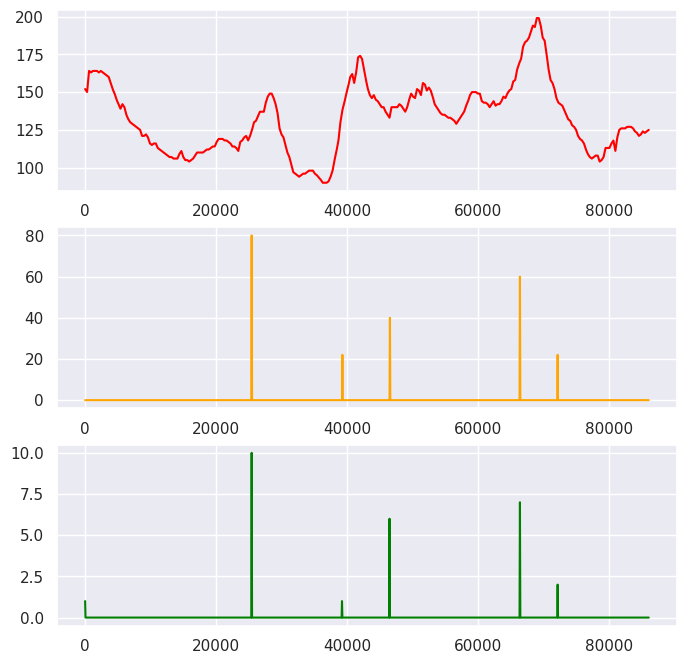

In [ ]:
# visualize data
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(data_t, data_CGM, label="CGM", color="red")
plt.subplot(3, 1, 2)
plt.plot(data_t, data_CHO, label="CHO", color="orange")
plt.subplot(3, 1, 3)
plt.plot(data_t, data_insulin, label="insulin", color="green")
plt.show()

In [ ]:
# required data structures
Action = namedtuple("patient_action", ['CHO', 'insulin'])

In [ ]:
# load parameters
orig_params = pd.read_csv("/content/PINN-CGM-1/parameters/vpatient_params.csv")
nominal_params = orig_params.mean(numeric_only=True)
est_params = ["kp2", "k1", "k2", "kp1", "ki", "ke1", "kmax", "kmin", "kabs", "kp3"]

# constrain parameters to be within the range
adult_params = orig_params[orig_params.Name.str.contains("adult")].loc[:, est_params]
p_range = np.stack([adult_params.min(), adult_params.max()], axis=1)
def constrain_params(p):
    return ((np.tanh(p) + 1) / 2) * (p_range[:, 1] - p_range[:, 0]) + p_range[:, 0]

# construct parameter dict
def construct_params(p):
    # p = [kp2, k1, k2, kp1, ki, ke1, kmax, kmin, kabs, kp3]
    return pd.Series({
        **nominal_params.drop("i").to_dict(),
        **dict(zip(est_params, constrain_params(p))),
    })

In [ ]:
# time
t_span = (data_t[0], data_t[-1])
t_eval = data_t

# initial conditions
u0 = nominal_params.iloc[2:15].to_numpy()

def output(params):
    patient = T1DPatient.withParams(params)

    t_trace = t_eval # np.arange(*t_span)
    BG_trace = []
    # dx_trace = []

    for t in t_trace:
        # get current action
        t_mask = np.abs(data_t - t).argmin()
        action = Action(CHO=data_CHO[t_mask], insulin=data_insulin[t_mask])

        # track variables
        BG_trace.append(patient.observation.Gsub)
        # dx_trace.append(patient.derivative)

        patient.step(action)

    BG_trace = np.array(BG_trace)
    # dx_trace = np.array(derivatives)

    return t_trace, BG_trace #, dx_trace

In [ ]:
# evolutionary algorithm parameters
NGEN = 100
SIGMA = 5
LAMBDA = 20

# target function
def evaluate(p):
    try:
        pred_t, pred_CGM = output(construct_params(p))
        return [np.sqrt(np.mean((np.log(pred_CGM + 1) - np.log(data_CGM + 1)) ** 2))]
    except:
        return [1e10]

# evolutionary algorithm setup
creator.create("FitnessMin", base.Fitness, weights=[-1.0])
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)

# enable multiprocessing
pool = mp.Pool()
toolbox.register("map", pool.map)

# inital parameter guess
p_guess = adult_params.mean().to_numpy()

# CMA-ES
strategy = cma.Strategy(centroid=p_guess, sigma=SIGMA, lambda_=LAMBDA)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

# track best individuals
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda i: i.fitness.values)
stats.register("avg_loss", np.mean)
stats.register("min_loss", np.min)
stats.register("max_loss", np.max)

/usr/local/lib/python3.9/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.9/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
from IPython.display import clear_output

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# train loop
def train(toolbox, ngen, stats, halloffame):
    loss_history = []
    for _ in range(ngen):
        # generate a new population
        population = toolbox.generate()

        # evaluate the individuals
        fitnesses = toolbox.map(toolbox.evaluate, population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        if halloffame is not None:
            halloffame.update(population)

        # update the strategy with the evaluated individuals
        toolbox.update(population)

        record = stats.compile(population) if stats is not None else {}
        loss_history.append(record["min_loss"])

        clear_output(wait=True)
        plt.plot(loss_history, "r.-")
        plt.show()

    return loss_history

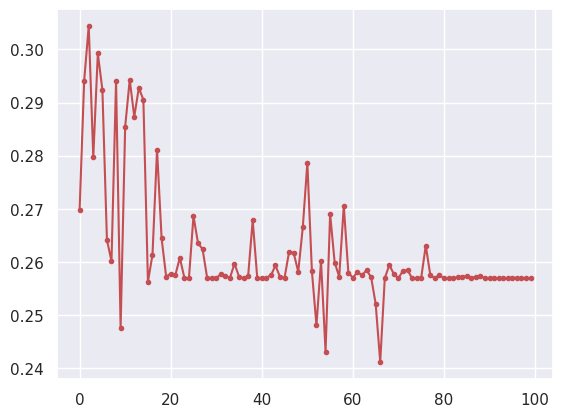

[0.2698005894261455,
 0.2940834338300075,
 0.30439960043679976,
 0.2797236074095549,
 0.2992501056778634,
 0.292404995195546,
 0.26413121823824526,
 0.2601386137329398,
 0.2940669320769554,
 0.24756788413704983,
 0.28542579579973176,
 0.2942693463145978,
 0.28735424039783714,
 0.2927504623013921,
 0.29052904389564327,
 0.2562533711857566,
 0.26135785003850065,
 0.281120729933281,
 0.26443907332929883,
 0.25724948311397994,
 0.257778208046171,
 0.25745114349564185,
 0.2607978057974179,
 0.2570145319151918,
 0.2569273453771082,
 0.2686322663313096,
 0.2635302954951468,
 0.2623858091244978,
 0.25701914471529674,
 0.2570018240646794,
 0.2569703055628323,
 0.25768174652081627,
 0.25738700858201397,
 0.2569673592394251,
 0.25967746051823765,
 0.25725022994813995,
 0.25692623001771503,
 0.25734072064456925,
 0.26784966450334574,
 0.2569953892171147,
 0.2569208444473186,
 0.25706213466522654,
 0.2574525516983464,
 0.2593430980056324,
 0.2571656723545216,
 0.2570377253132892,
 0.261955254125827

In [ ]:
train(toolbox, NGEN, stats, hof)

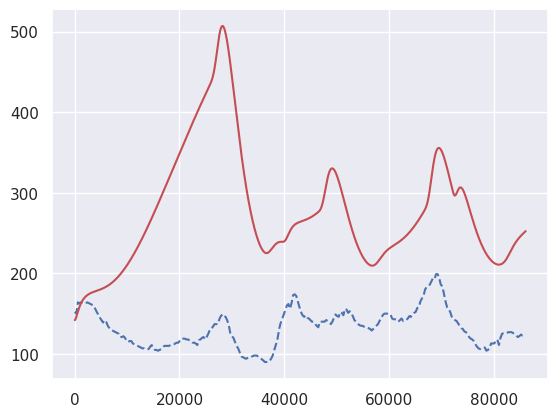

In [ ]:
p = adult_params.mean().to_numpy()
pred_t, pred_CGM = output(construct_params(p))
plt.plot(data_t, data_CGM, "b--")
plt.plot(pred_t, pred_CGM, "r")
plt.show()